<a href="https://colab.research.google.com/github/jjungmini/solar/blob/main/pv_lstm_1010_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

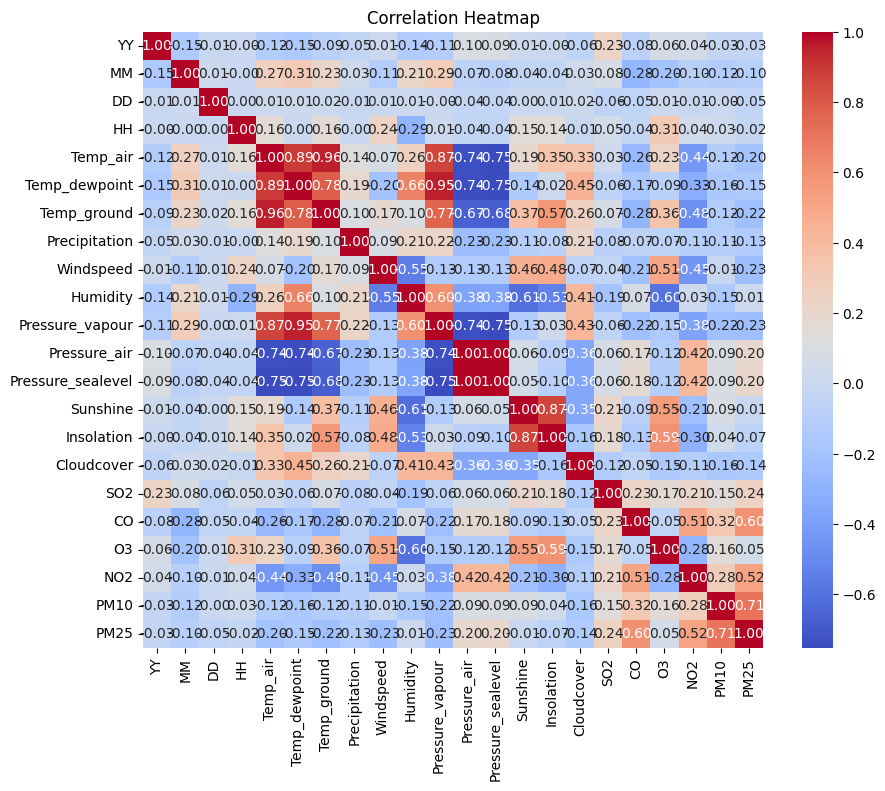

In [31]:
# 데이터 로딩
df = pd.read_csv('solar_with_emissions_0228.csv')

# 날짜를 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d-%H')

# 타겟 변수를 위한 별도의 스케일러 정의
target_scaler = MinMaxScaler()
df['Solarpower'] = target_scaler.fit_transform(df[['Solarpower']])

# 특성만 정규화하기 위해 Scaler 정의
scaler = MinMaxScaler()
# Solarpower 제외하고 정규화
features = df.drop(columns=['Date', 'Solarpower'])
df[features.columns] = scaler.fit_transform(features)

# 특성들 간의 상관관계 계산을 위해 타겟 변수 제외
correlation_matrix = df.drop(columns=['Date', 'Solarpower']).corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [32]:
# 훈련 데이터와 테스트 데이터로 분리
train = df[df['Date'] < '2022-12-01']
test = df[(df['Date'] >= '2022-12-01') & (df['Date'] < '2023-01-01')]

# feature selection

In [33]:
# 훈련 데이터를 이용하여 특성 선택을 위한 ElasticNetCV 모델을 생성합니다
enet_train = ElasticNetCV(
    alphas=[0.001, 0.01, 0.1, 1, 10],        # 후보 alpha 값 리스트
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],     # 후보 l1_ratio 값 리스트
    cv=5,                                   # 5-fold cross-validation 사용
    n_alphas=1000,                           # 100개의 alpha 값 생성
    max_iter=1000,                          # 최대 반복 횟수
    tol=1e-4,                               # 수렴 기준
    verbose=False,                          # 로그 출력 비활성화
    precompute='auto',                      # 자동으로 사전 계산된 Gram 행렬 결정
    selection='random',                      # 랜덤하게 특성 선택
    random_state=42
)
enet_train.fit(train.drop(columns=['Date', 'Solarpower', 'YY', 'MM', 'DD', 'HH', 'Pressure_sealevel', 'CO', 'O3', 'NO2']), train['Solarpower'])
# alpha 값을 출력합니다.
print('Best alpha: ', enet_train.alpha_)

# 선택된 특성만 남김
selected_features_train = train.drop(columns=['Date', 'Solarpower',  'YY', 'MM', 'DD', 'HH', 'Pressure_sealevel', 'CO', 'O3', 'NO2']).columns[enet_train.coef_ != 0]
train = train[['Date', 'Solarpower'] + selected_features_train.tolist()]

# 선택된 특성 출력
print("Selected features: ", selected_features_train.tolist())

Best alpha:  0.001
Selected features:  ['Temp_air', 'Windspeed', 'Pressure_air', 'Sunshine', 'Insolation', 'SO2']


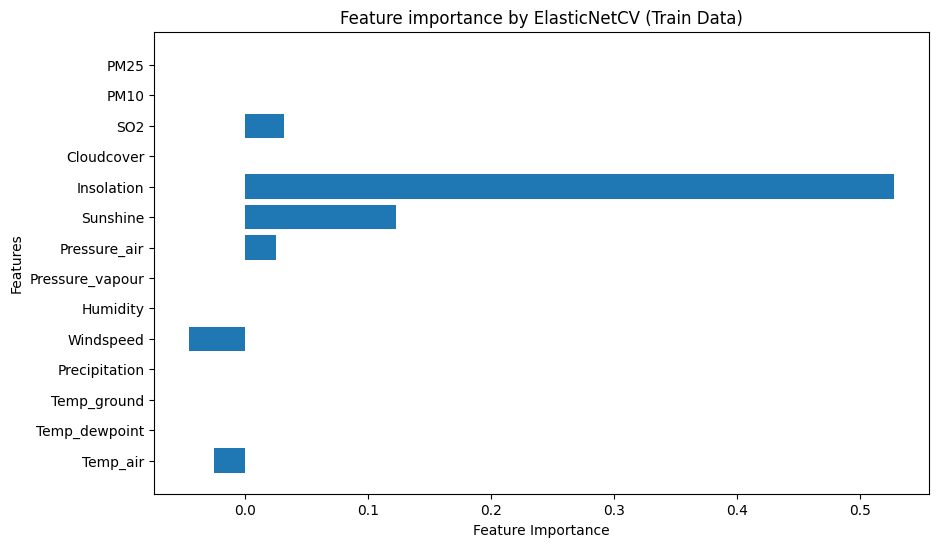

In [34]:
# ElasticNetCV의 결과를 출력합니다.
# 특성 중요도를 시각화합니다.
plt.figure(figsize=(10, 6))
plt.barh(range(len(enet_train.coef_)), enet_train.coef_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.yticks(range(len(enet_train.coef_)), enet_train.feature_names_in_)
plt.title('Feature importance by ElasticNetCV (Train Data)')
plt.show()

In [35]:
#선택된 특성 데이터 셋
train = train[['Date', 'Solarpower'] + selected_features_train.tolist()].set_index(['Date'], drop=True)
test = test[['Date', 'Solarpower'] + selected_features_train.tolist()].set_index(['Date'], drop=True)

In [36]:
test.shape

(744, 7)

# LSTM

In [37]:
pip install tensorflow

In [38]:
# tensorflow.python.keras을 사용하면 fit 함수 안돌아감
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [39]:
# data reformatting for LSTM
pred_days = 24  # prediction period
seq_len = 168 # sequence length = past days for future prediction.
input_dim = 6  # input_dimension = ['Open', 'High', 'Low', 'Close', 'Volume']

lstm_X_train = []
lstm_y_train = []
lstm_X_test = []
lstm_y_test = []

for i in range(seq_len, train.shape[0]-pred_days +1):
    lstm_X_train.append(train.iloc[i - seq_len:i, 1:])
    lstm_y_train.append(train.iloc[i:i + pred_days, 0])

for i in range(seq_len, len(test)-pred_days +1):
    lstm_X_test.append(test.iloc[i - seq_len:i, 1:])
    lstm_y_test.append(test.iloc[i:i + pred_days, 0])

lstm_X_train, lstm_y_train = np.array(lstm_X_train), np.array(lstm_y_train)
lstm_X_test, lstm_y_test = np.array(lstm_X_test), np.array(lstm_y_test)

In [19]:
lstm_y_train = lstm_y_train[:,:,np.newaxis]
lstm_y_test = lstm_y_test[:,:,np.newaxis]
print(lstm_y_train.shape)
print(lstm_y_test.shape)

(25369, 24, 1)
(553, 24, 1)


In [20]:
# 모델 생성
model=Sequential()
model.add(LSTM(units=64,return_sequences=True,input_shape= (lstm_X_train.shape[1], lstm_X_train.shape[2])))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(lstm_y_train.shape[1]))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 168, 64)           18176     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
Total params: 31384 (122.59 KB)
Trainable params: 31384 (122.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# 모델 학습
model.fit(lstm_X_train, lstm_y_train)

793/793 [==============================] - 138s 169ms/step - loss: 0.0128


In [22]:
prediction = model.predict(lstm_X_test)
print(prediction.shape, lstm_y_test.shape)

18/18 [==============================] - 2s 43ms/step
(553, 24) (553, 24, 1)


In [23]:
#예측된 값을 원래 스케일로 역변환
predictions = target_scaler.inverse_transform(prediction)
# 테스트 데이터셋의 실제 타겟 변수 값을 가져옴
actual_values = target_scaler.inverse_transform(lstm_y_test.reshape(-1, 1))

In [24]:
# MAPE 계산 함수 정의
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

평균 제곱 오차 (MSE): 912.5539635390877
평균 절대 오차 (MAE): 20.208699206163853
결정 계수 (R2): 0.8308793122260678
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 30.208508131635494


<ipython-input-103-d65f9915a241>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


ValueError: ignored

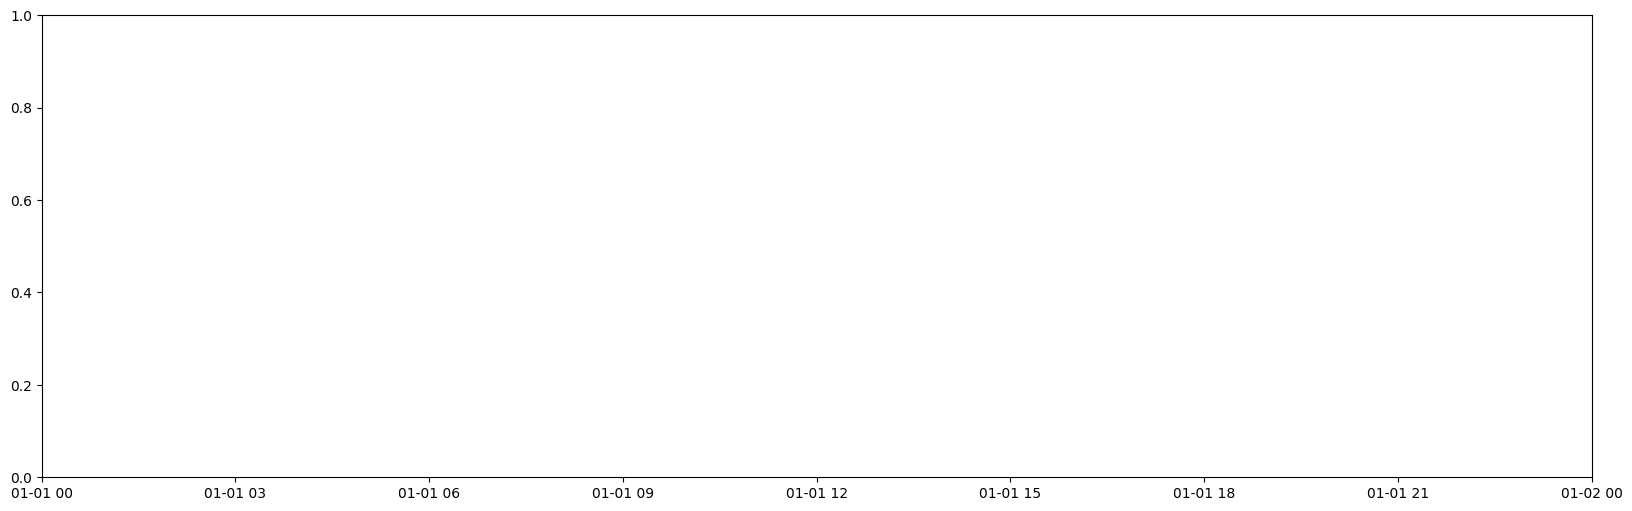

In [ ]:
# 평가 지표 계산
mse = mean_squared_error(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)
mape = mean_absolute_percentage_error(actual_values, predictions)
rmse = np.sqrt(mse)

# 평가 지표 출력
print("평균 제곱 오차 (MSE):", mse)
print("평균 절대 오차 (MAE):", mae)
print("결정 계수 (R2):", r2)
print("평균 절대 백분율 오차 (MAPE):", mape)
print("평균 제곱근 오차 (RMSE):", rmse)

# 실제 값과 예측값 시각화
plt.figure(figsize=(20, 6))
plt.plot(test['Date'], actual_values, label='Actual', marker='o')
plt.plot(test['Date'], predictions, label='Forecasted', marker='o')
plt.xlabel('Date')
plt.ylabel('Power Generation')
plt.title('Actual vs. Forecasted')
plt.legend()
plt.show()